In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pymc3 as pm
from scipy.stats import distributions as dist
import arviz as az

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Student\PycharmProjects\merge\venv\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def cos(x):
    return np.cos(2*np.pi*x)

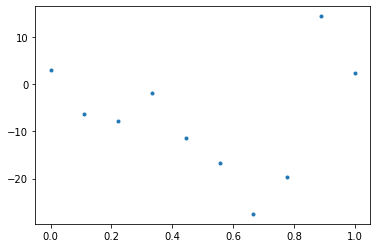

In [3]:
x = np.linspace(0,1,10)
y = cos(x)
e = dist.norm(0,12).rvs(len(x))
y_obs = cos(x) + e
plt.plot(x,y_obs, '.')

In [4]:
p_1 = np.poly1d(np.polyfit(x,y_obs, deg = 1))
p_2 = np.poly1d(np.polyfit(x,y_obs, deg = 2))
p_3 = np.poly1d(np.polyfit(x,y_obs, deg = 3))
p_4 = np.poly1d(np.polyfit(x,y_obs, deg = 4))
p_5 = np.poly1d(np.polyfit(x,y_obs, deg = 5))
p_6 = np.poly1d(np.polyfit(x,y_obs, deg = 6))
p_7 = np.poly1d(np.polyfit(x,y_obs, deg = 7))
p_8 = np.poly1d(np.polyfit(x,y_obs, deg = 8))
p_9 = np.poly1d(np.polyfit(x,y_obs, deg = 9))
new_x = np.linspace(0,1, 100)

In [5]:
p_1

poly1d([-0.13434598, -7.07077194])

Text(0.5, 1.0, 'Degree 9')

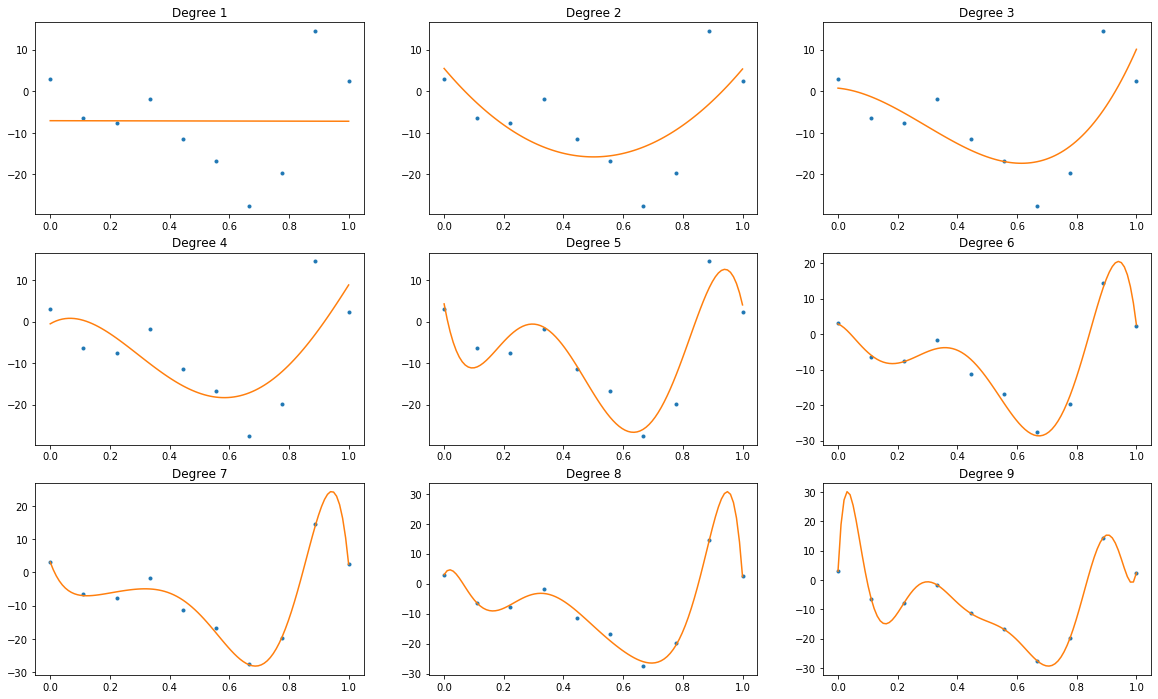

In [6]:
_, axi = plt.subplots(3,3, figsize=(20,12))
axi[0][0].plot(x, y_obs, '.', new_x, p_1(new_x))
axi[0][0].set_title("Degree 1")
axi[0][1].plot(x, y_obs, '.', new_x, p_2(new_x))
axi[0][1].set_title("Degree 2")
axi[0][2].plot(x, y_obs, '.', new_x, p_3(new_x))
axi[0][2].set_title("Degree 3")
axi[1][0].plot(x, y_obs, '.', new_x, p_4(new_x))
axi[1][0].set_title("Degree 4")
axi[1][1].plot(x, y_obs, '.', new_x, p_5(new_x))
axi[1][1].set_title("Degree 5")
axi[1][2].plot(x, y_obs, '.', new_x, p_6(new_x))
axi[1][2].set_title("Degree 6")
axi[2][0].plot(x, y_obs, '.', new_x, p_7(new_x))
axi[2][0].set_title("Degree 7")
axi[2][1].plot(x, y_obs, '.', new_x, p_8(new_x))
axi[2][1].set_title("Degree 8")
axi[2][2].plot(x, y_obs, '.', new_x, p_9(new_x))
axi[2][2].set_title("Degree 9")

In [7]:
from prettytable import PrettyTable

table = PrettyTable(['p_1',' p_2','p_3','p_4','p_5','p_6','p_7','p_8','p_9'])

for x in range(0,10):
    table.add_row(np.round([p_1[x],p_2[x],p_3[x],p_4[x],p_5[x],p_6[x],p_7[x],p_8[x],p_9[x]],2))

In [8]:
print(table)
# The rows represents the weights, the columns represents the degrees of the line fitting the points

+-------+--------+---------+---------+----------+-----------+-----------+------------+-------------+
|  p_1  |   p_2  |   p_3   |   p_4   |   p_5    |    p_6    |    p_7    |    p_8     |     p_9     |
+-------+--------+---------+---------+----------+-----------+-----------+------------+-------------+
| -7.07 |  5.5   |   0.76  |  -0.55  |   4.25   |    2.89   |    3.09   |    3.03    |     3.01    |
| -0.13 | -84.99 |  -6.94  |   42.1  | -394.57  |   -33.63  |  -247.19  |   189.41   |   2027.41   |
|  0.0  | 84.85  | -120.84 | -368.51 | 3271.41  |  -1181.64 |  2342.26  |  -6462.46  |  -48916.96  |
|  0.0  |  0.0   |  137.13 |  534.38 | -9754.47 |   9411.9  | -11485.22 |  54925.1   |  437328.38  |
|  0.0  |  0.0   |   0.0   | -198.63 | 11594.72 | -25443.81 |  33644.06 | -216885.19 | -2013364.81 |
|  0.0  |  0.0   |   0.0   |   0.0   | -4717.34 |  28229.09 | -57938.26 | 463639.57  |  5357917.32 |
|  0.0  |  0.0   |   0.0   |   0.0   |   0.0    | -10982.14 |  51550.05 | -556957.42 | -857

Looking at the graphs and points in the table I can clearly see that the number of weights increases as the number of degrees increases. With an increase in the number of weights the greater the chance of the line fitting the points. 

In [9]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y, y_obs))
print(rmse)

13.396764317451048


In [11]:
with pm.Model() as LinearModel:
    #priors
    w_0 = pm.Normal('Intercepts', mu = 0, sigma = 10, shape = 1)
    w = pm.Normal('weights', mu = 0, sigma = 10, shape = 10)
    sigma = pm.HalfCauchy('sigma', 10)
    #Computing mean
    mu = pm.Deterministic('mu', w_0 + w[1]*cos(x) + w[2]*cos(x)**2 + w[3]*cos(x)**3 + w[4]*cos(x)**4 + w[5]*cos(x)**5 + w[6]*cos(x)**6 + w[7]*cos(x)**7 + w[8]*cos(x)**8 + w[9]*cos(x)**9)
    #mu = pm.Deterministic('mu', w_0 + pm.math.dot(x, w))
    #likelihood
    y_ob = pm.Normal('y_ob', mu = mu, sigma = sigma, observed = y_obs)
    trace = pm.sample(2000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, weights, Intercepts]
Sampling 2 chains, 11 divergences: 100%|██████████| 6000/6000 [09:36<00:00, 10.40draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\Student\PycharmProjects\merge\venv\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Student\PycharmProjects\merge\venv\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Student\PycharmProjects\merge\venv\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Student\PycharmProjects\merge\venv\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not ef

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000235C6296860>,
      dtype=object)

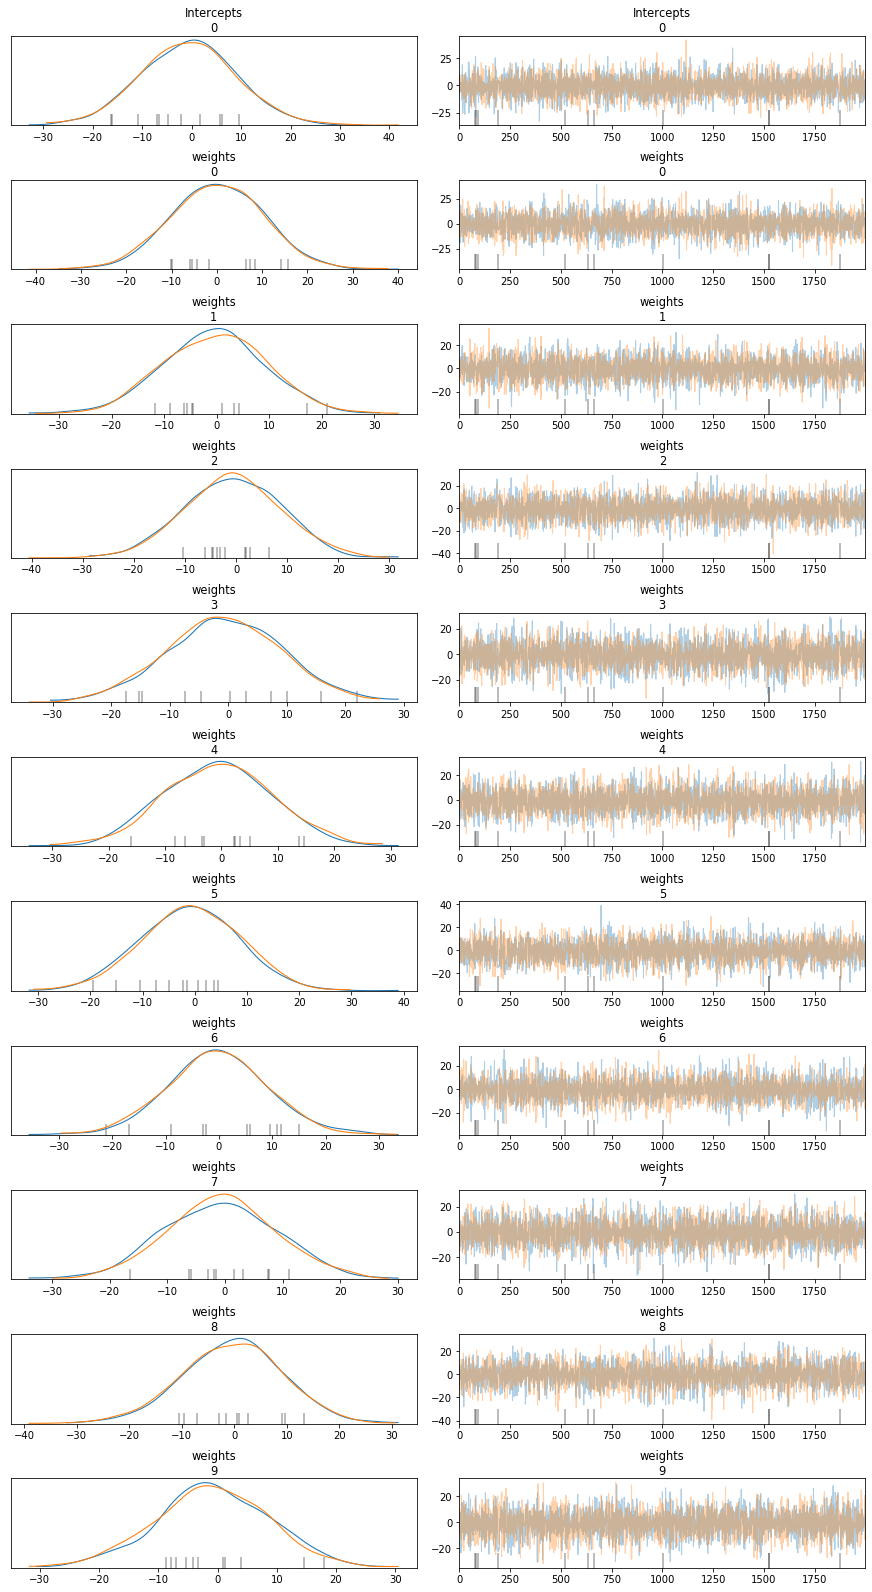

In [12]:
az.plot_trace(trace , var_names = ["Intercepts", "weights"])